# Clusterização e Análise - Facebook Posts of Amazon Tourism

*   Desenvolvedora: Paula Jeniffer dos Santos Viriato
*   Projeto: NIHER - Non-invasive and Highly Explainable Recommendations
*   Data: 08 de abril de 2023

In [1]:
#Initial Settings
!pip install umap-learn &> initial_setting.log
!pip install pyldavis &> initial_setting.log
!pip install pandas==1.1.5 --upgrade &> initial_setting.log
!pip install numpy==1.19.5 --upgrade &> initial_setting.log

In [2]:
import os
import json
import csv
import random
import numpy
import nltk
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('portuguese')
fwords = open("stopwords.txt", "r")
n_stopwords = fwords.readlines()
for word in n_stopwords:
    if (word not in stopwords):
        stopwords.append(word)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
data, columns = [], []
with open('facebook_posts_amazon_tourism.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        if (len(columns) == 0):
            for item in row: columns.append(item)
        else:
            newdata = {}
            for i in range(len(row)): newdata[columns[i]] = row[i]
            data.append(newdata)

In [52]:
X, y = [], []

for item in data:
    X.append(item['status_message'])
    if (item['category'] == 'N/A'): y.append(0)
    else: y.append(int(item['category'])+1)

In [53]:
cvec = TfidfVectorizer(stop_words=stopwords, max_features=5000, max_df=.95, min_df=5)
xtrain_vec = cvec.fit_transform(X)

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['havia', 'ter', 'têm'] not in stop_words.
  warnings.warn(


In [54]:
tsne = TSNE(random_state=42, init="random")
xtrain_tsne = tsne.fit_transform(xtrain_vec)
utterances = list(set([i for i in y]))
y_pseudo = [[1 if ut == i else 0 for i in y] for ut in utterances]

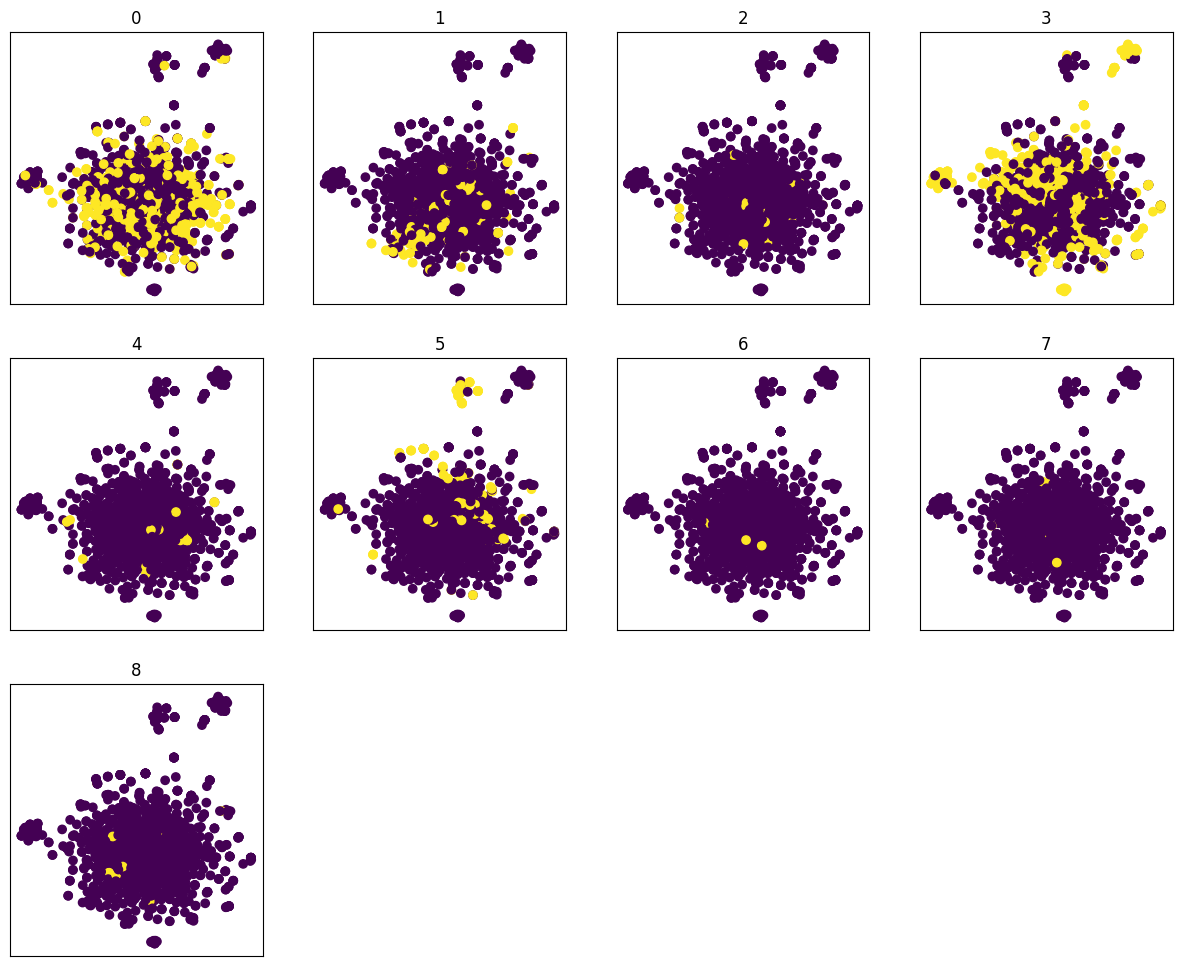

In [55]:
sizeut = len(utterances)
fig, axes = plt.subplots(3, sizeut//3+1, figsize=(15, 12), sharex=True)
axes = axes.flatten()
for i in range(3*(sizeut//3+1)):
    if i >= sizeut:
        axes[i].axis('off')
    else:
        axes[i].set_title(utterances[i])
        axes[i].scatter(xtrain_tsne[:,0], xtrain_tsne[:,1], c=y_pseudo[i]);
        axes[i].set_xticks([])
        axes[i].set_yticks([])

In [56]:
n_compo = int(input("Number of Components: "))
m_index = int(input("Model (0 = LDA; 1 = NMF): "))

model = None
if (m_index == 0):
    model = LatentDirichletAllocation(n_components=n_compo, random_state=42)
else: model = NMF(n_components=n_compo, random_state=42)

topics = model.fit_transform(xtrain_vec)
ytopics = [item.tolist().index(max(item)) for item in topics]

Number of Components: 8
Model (0 = LDA; 1 = NMF): 1


In [59]:
df = pd.DataFrame(topics, columns=[i for i in range(n_compo)])
df['ytopics'] = [str(topic) for topic in ytopics]
df['y'] = [str(topic) for topic in y]

In [60]:
sample = df.sample(20, random_state=42)
sample.style.background_gradient(cmap='Reds', axis=1)\
      .format({x:"{:0.3f}" for x in range(n_compo)})

,0,1,2,3,4,5,6,7,ytopics,y
528,0.000,0.000,0.000,0.377,0.000,0.000,0.000,0.000,3,5
914,0.000,0.000,0.051,0.000,0.000,0.026,0.007,0.000,2,6
587,0.000,0.000,0.000,0.377,0.000,0.000,0.000,0.000,3,0
31,0.000,0.004,0.115,0.000,0.053,0.035,0.000,0.000,2,5
136,0.004,0.002,0.018,0.000,0.000,0.000,0.005,0.000,2,3
730,0.215,0.000,0.000,0.128,0.000,0.000,0.000,0.000,0,3
298,0.000,0.000,0.065,0.000,0.000,0.000,0.000,0.000,2,3
946,0.000,0.000,0.082,0.001,0.000,0.000,0.010,0.000,2,3
398,0.004,0.000,0.129,0.004,0.000,0.000,0.000,0.000,2,3
597,0.000,0.000,0.000,0.000,0.287,0.000,0.000,0.000,4,5


In [61]:
X[334]

'Você já sabe, né?\r\n🍻 HOJE E AMANHÃ É DIA DE HAPPY HOUR EL PATRON🍻\r\nChopp Devassa em dobro toda terça e quarta!!!\r\nAproveite nosso cardápio de entradas com preços super especiais.\r\nChama a galera e vem curtir!\r\n👉Das 18h30 às 21h#\r\n...\r\n#HappyHourElPatron #ElPatron #ChoppEmDobro'

In [62]:
def plot_top_words(model, n_components, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, n_components, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

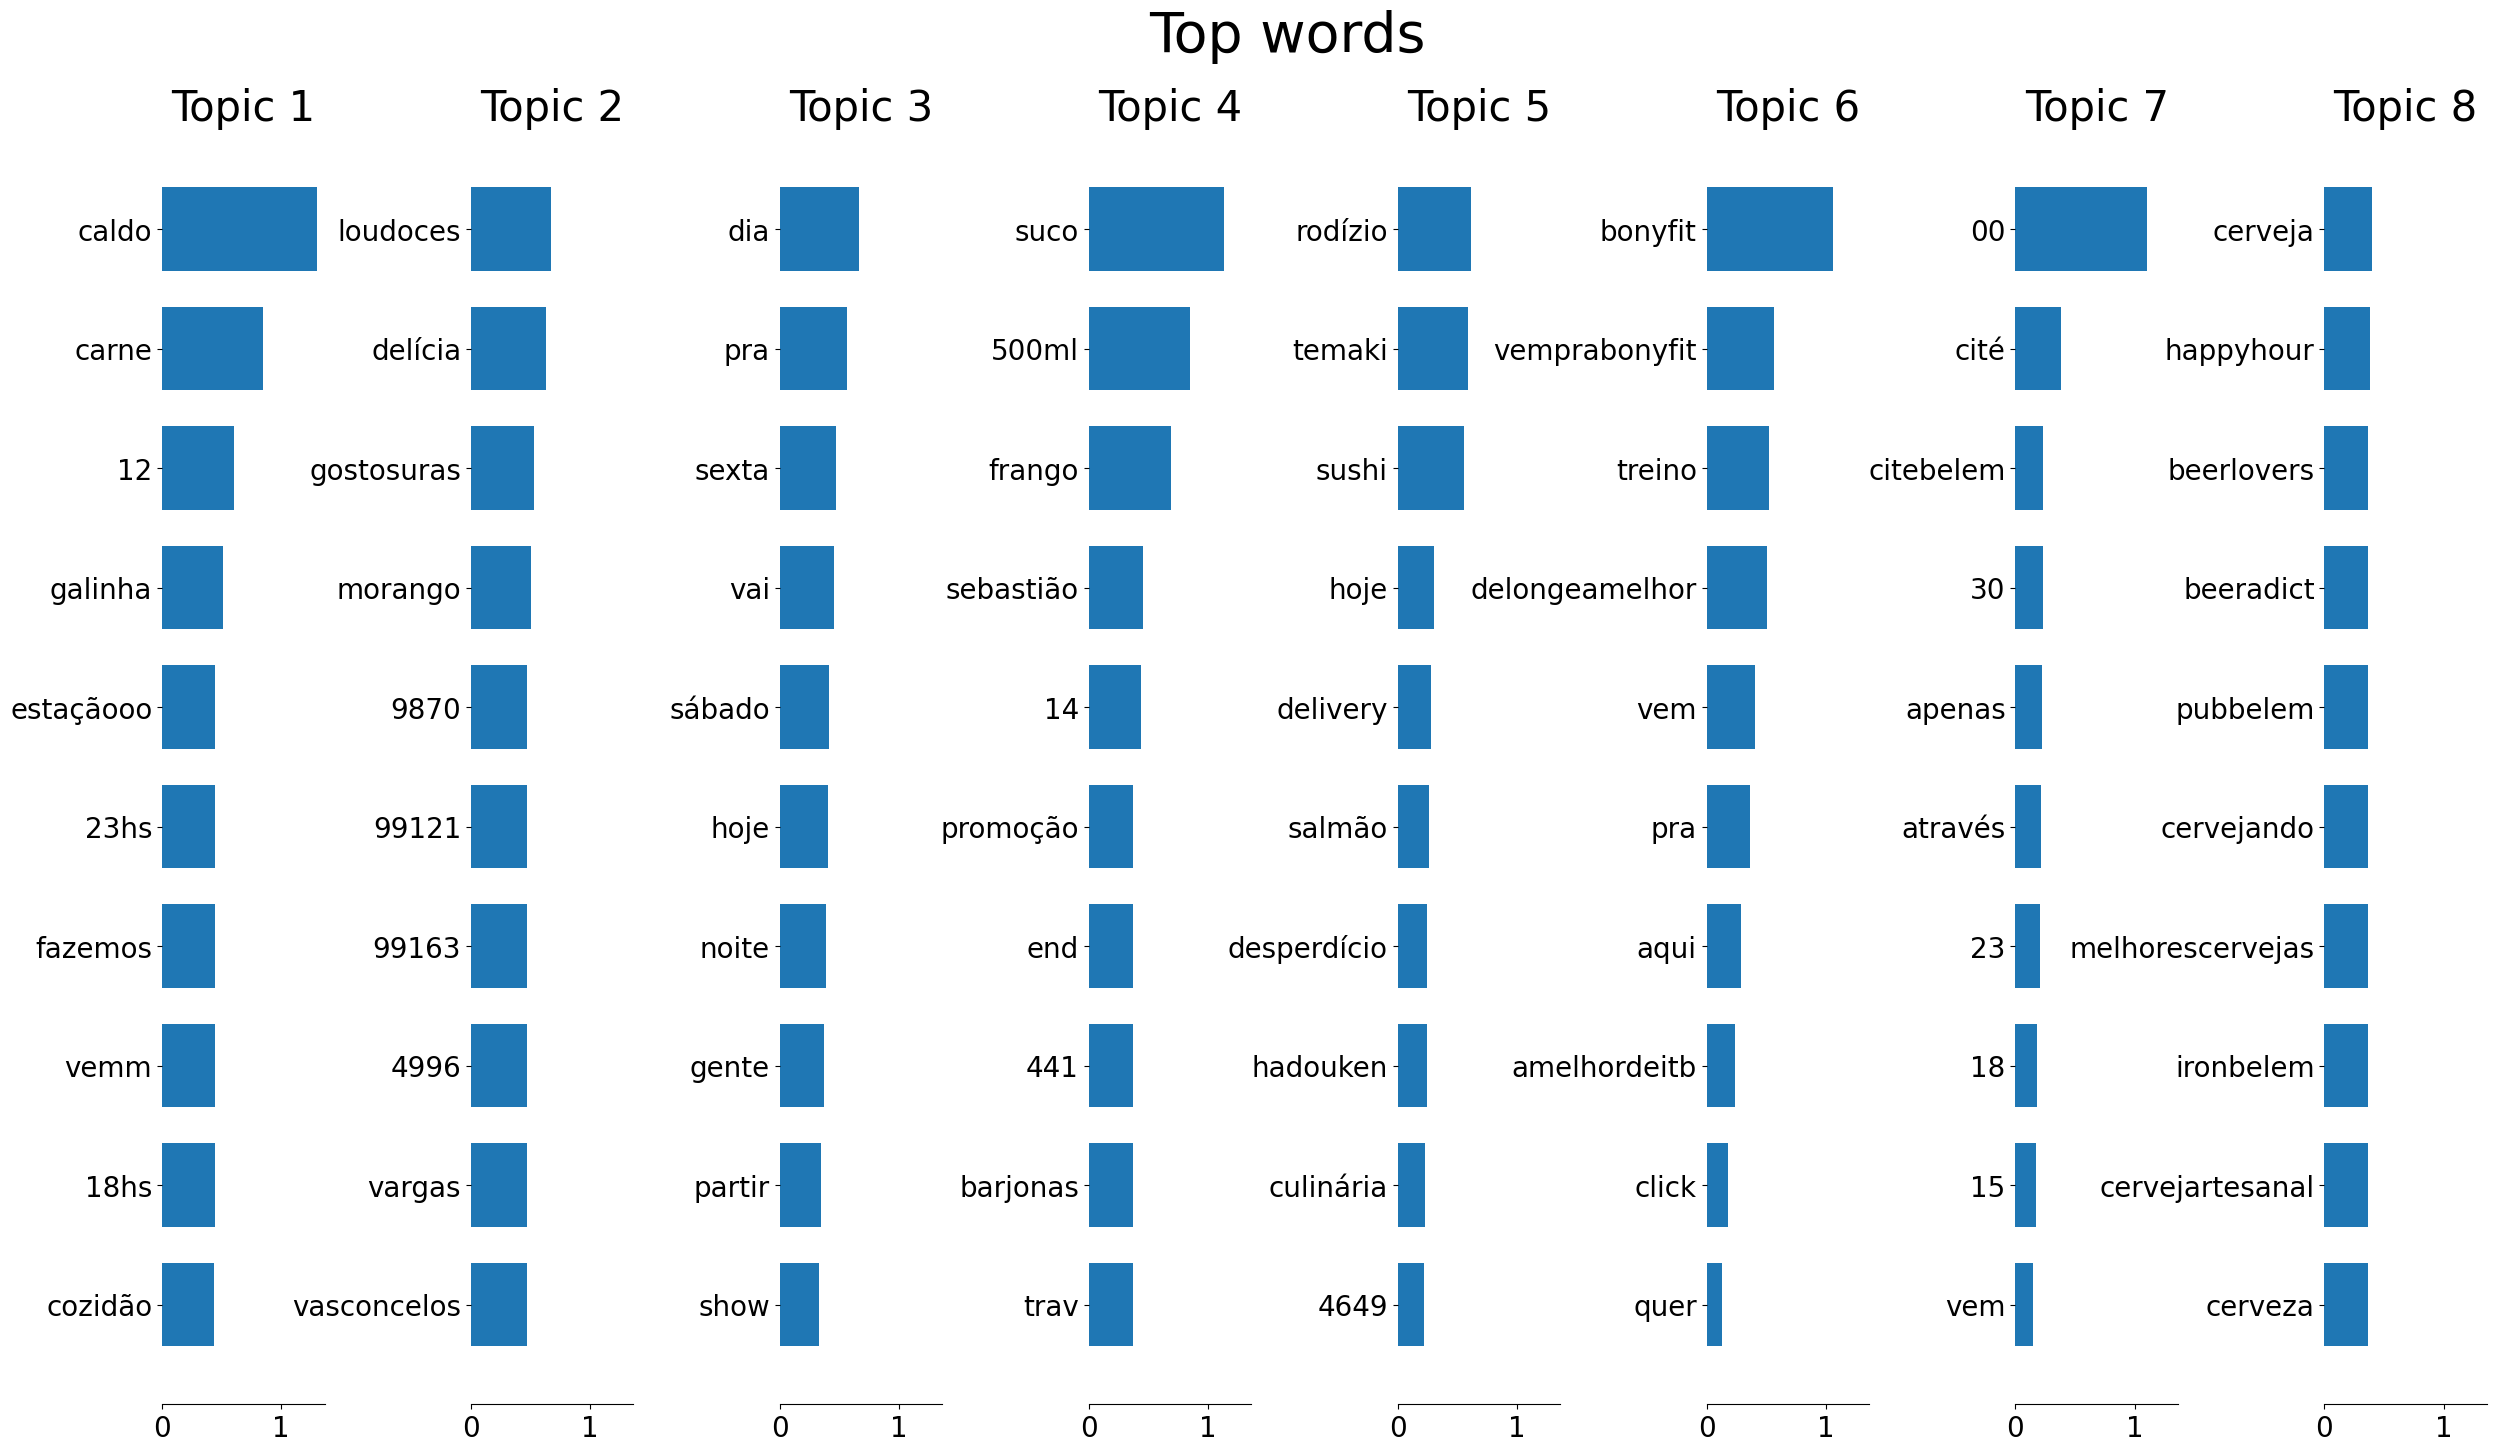

In [67]:
plot_top_words(model, n_compo, cvec.get_feature_names_out(), 10, "Top words")

Index of Topic: 3


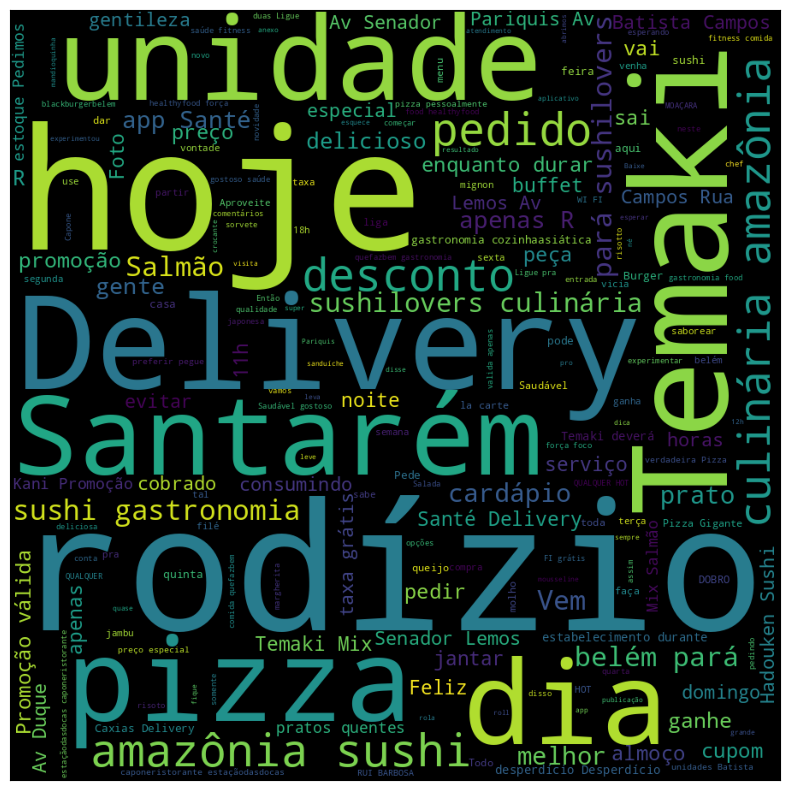

In [66]:
t_index = int(input("Index of Topic: "))+1
text = ""
for i in range(len(ytopics)):
    if (ytopics[i] == t_index): text += X[i]

wordcloud = WordCloud(width = 900, height = 900,
                      stopwords = stopwords).generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.yticks([])
plt.xticks([])
plt.show()

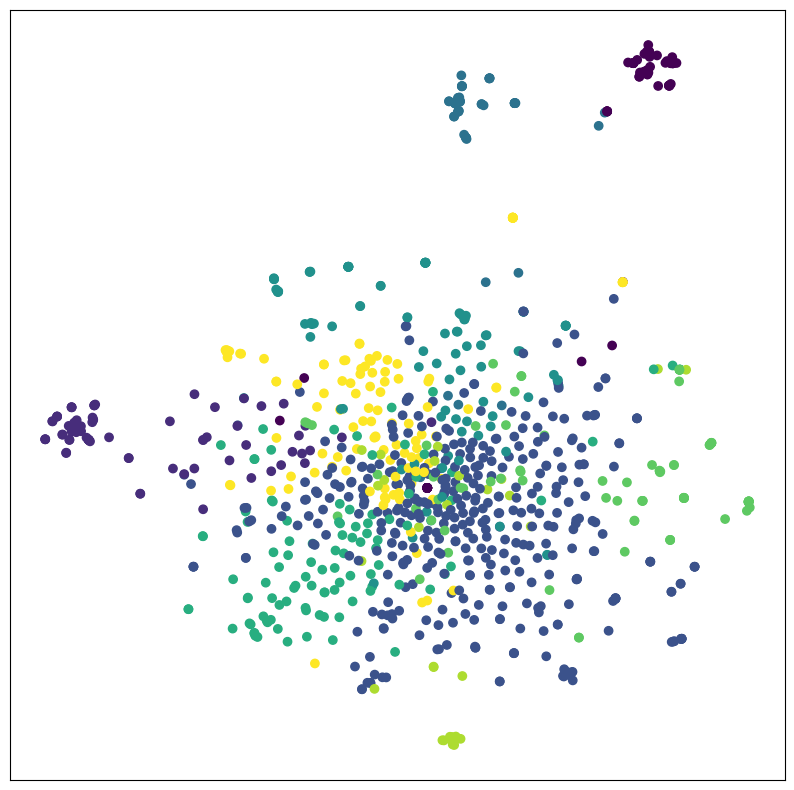

In [49]:
plt.figure(figsize=(10,10))
plt.scatter(xtrain_tsne[:,0], xtrain_tsne[:,1], c = ytopics)
plt.yticks([])
plt.xticks([])
plt.show()

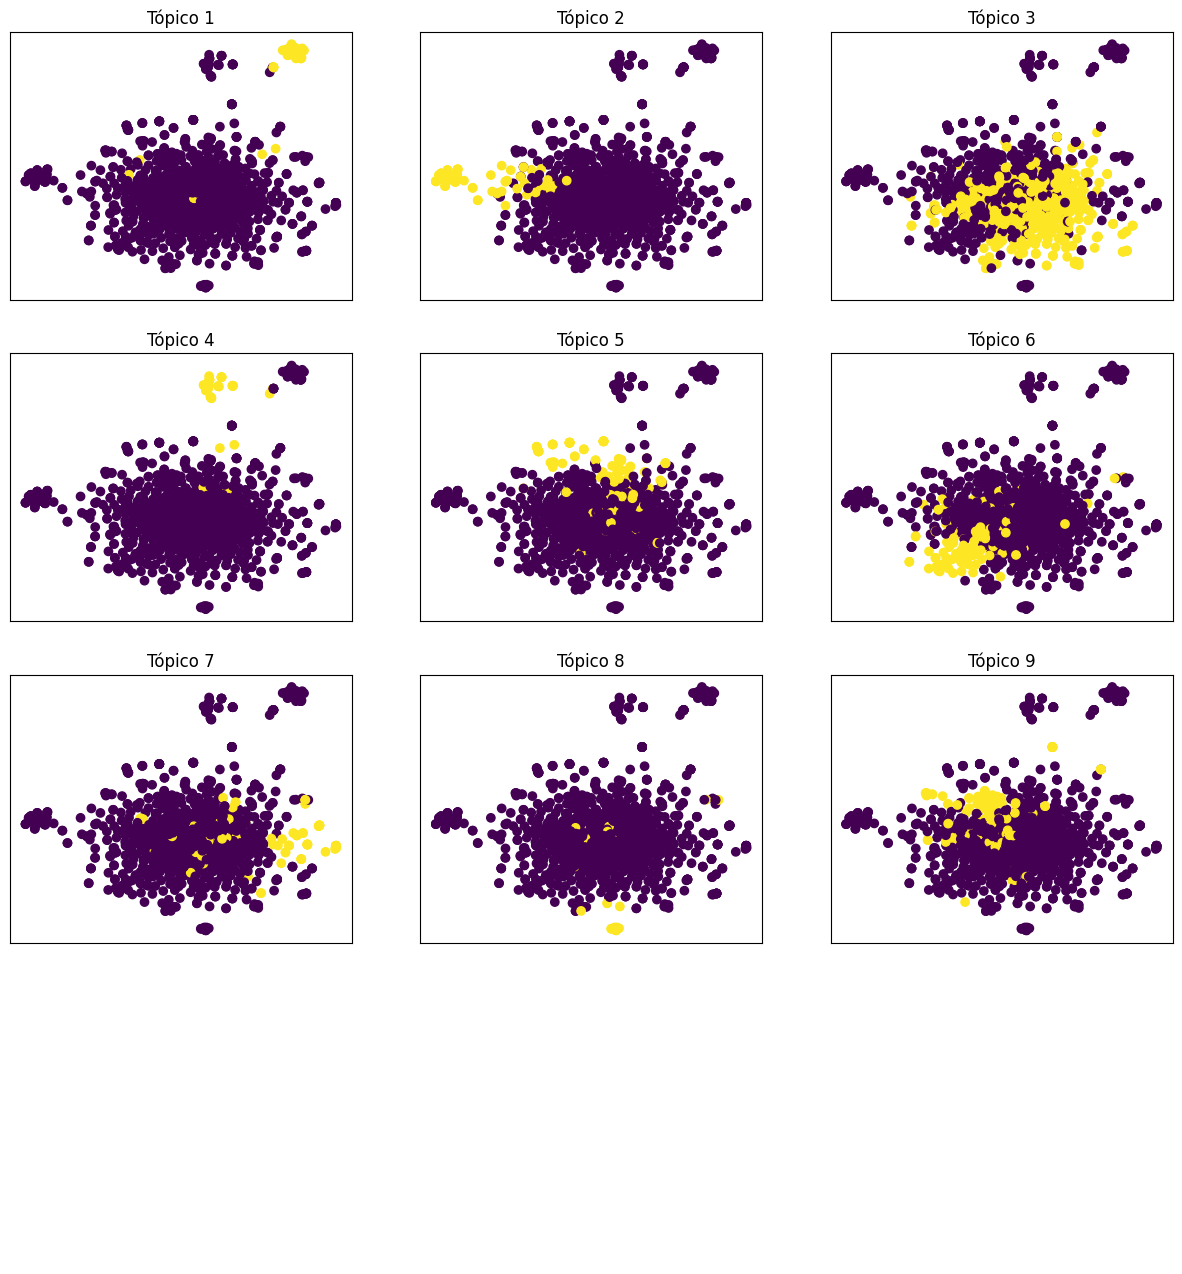

In [50]:
fig, axes = plt.subplots(n_compo//3+1, 3, figsize=(15, 4*(n_compo//3+1)), sharex=True)
axes = axes.flatten()
for i in range(3*(n_compo//3+1)):
    if i >= n_compo:
        axes[i].axis('off')
    else:
        ycurrent = [1 if j == i else 0 for j in ytopics]
        axes[i].set_title("Tópico "+str(i+1))
        axes[i].scatter(xtrain_tsne[:,0], xtrain_tsne[:,1], c=ycurrent);
        axes[i].set_xticks([])
        axes[i].set_yticks([])

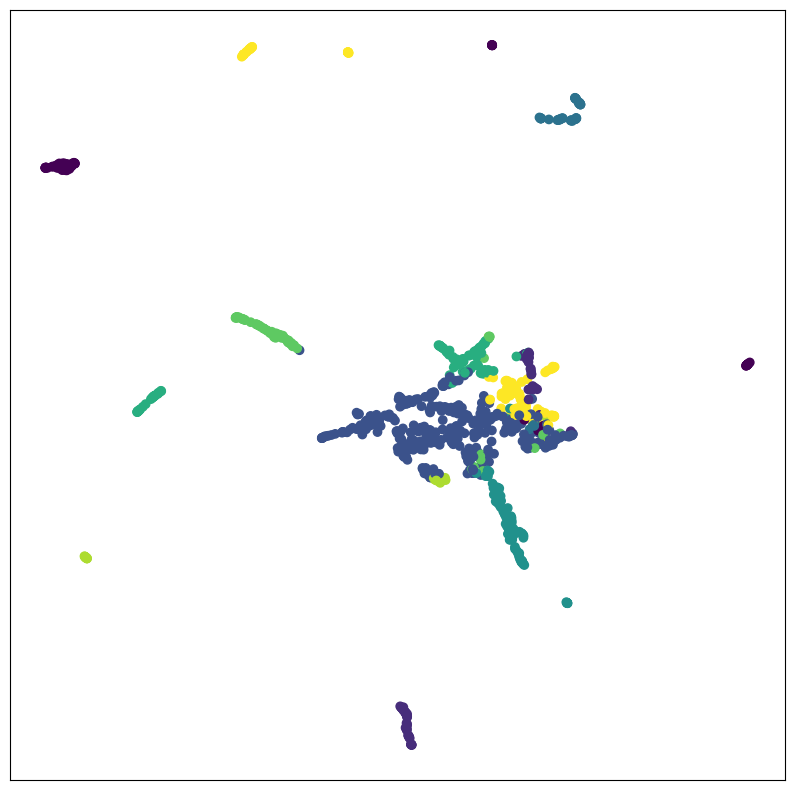

In [51]:
import umap
embedding = umap.UMAP(random_state=42).fit_transform(topics)
plt.figure(figsize=(10,10))
plt.scatter(embedding[:, 0], embedding[:, 1], c = ytopics)
plt.yticks([])
plt.xticks([])
plt.show()

In [105]:
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(model, xtrain_vec, cvec)

AttributeError: ignored

# Referências

1.   BUDZIANOWSKI, Paweł et al. MultiWOZ--A Large-Scale Multi-Domain Wizard-of-Oz Dataset for Task-Oriented Dialogue Modelling. **arXiv preprint arXiv:1810.00278**, 2018.
2.   BAEZA-YATES, Ricardo et al. **Modern information retrieval**. New York: ACM press, 1999.
3.   SCHÜTZE, Hinrich; MANNING, Christopher D.; RAGHAVAN, Prabhakar. **Introduction to information retrieval**. Cambridge: Cambridge University Press, 2008.
4.   VAN DER MAATEN, Laurens; HINTON, Geoffrey. Visualizing data using t-SNE. **Journal of machine learning research**, v. 9, n. 11, 2008.
5.   HOFFMAN, Matthew; BACH, Francis; BLEI, David. Online learning for latent dirichlet allocation. **advances in neural information processing systems**, v. 23, p. 856-864, 2010.
6.   CICHOCKI, Andrzej; PHAN, Anh-Huy. Fast local algorithms for large scale nonnegative matrix and tensor factorizations. **IEICE transactions on fundamentals of electronics, communications and computer sciences**, v. 92, n. 3, p. 708-721, 2009.
7.   MCINNES, Leland; HEALY, John; MELVILLE, James. Umap: Uniform manifold approximation and projection for dimension reduction. **arXiv preprint arXiv:1802.03426**, 2018.